In [1]:
%%capture
!pip3 install networkx

In [15]:
import networkx as nx
import random
import math

In [16]:
G = nx.Graph()

In [17]:
G.add_node(1,contracted=False)
G.add_node(2,contracted=False)
G.add_node(3,contracted=False)
G.add_node(4,contracted=False)
G.add_node(5,contracted=False)
G.add_node(6,contracted=False)
G.add_node(7,contracted=False)
G.add_node(8,contracted=False)
G.add_node(9,contracted=False)
G.add_node(10,contracted=False)
G.add_node(11,contracted=False)
G.add_node(12,contracted=False)
G.add_node(13,contracted=False)
G.add_node(14,contracted=False)

In [18]:
edges = [
    (1,2,{'weight':1}),
    (1,3,{'weight':4}),
    (1,7,{'weight':7}),
    (2,3,{'weight':5}),
    (2,4,{'weight':2}),
    (3,4,{'weight':2}),
    (3,6,{'weight':1}),
    (3,7,{'weight':2}),
    (3,8,{'weight':1}),
    (3,9,{'weight':1}),
    (4,5,{'weight':5}),
    (5,10,{'weight':7}),
    (6,7,{'weight':4}),
    (6,8,{'weight':3}),
    (6,10,{'weight':3}),
    (6,5,{'weight':3}),
    (6,9,{'weight':1}),
    (7,8,{'weight':6}),
    (8,9,{'weight':3}),
    (8,13,{'weight':5}),
    (9,12,{'weight':1}),
    (9,10,{'weight':3}),
    (10,11,{'weight':4}),
    (11,12,{'weight':3}),
    (11,13,{'weight':4}),
    (12,13,{'weight':2}),
    (14,1,{'weight':3}),
    (14,13,{'weight':2})
]

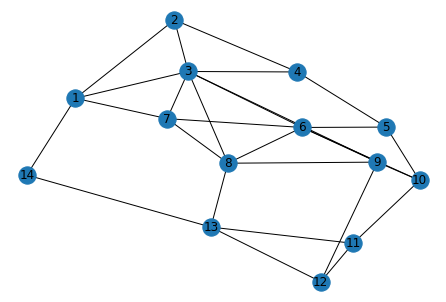

In [19]:
G.add_edges_from([*edges])
nx.draw(G,with_labels=True)

In [20]:
def dijkstra_with_contraction(G, source, destination, contracted = None):
    nx.set_node_attributes(G, {contracted: True}, 'contracted')
        
    shortest_path = dict()
    heap = list()
    
    for i in G.nodes():
        if not nx.get_node_attributes(G, 'contracted')[i]:
            shortest_path[i] = math.inf
            heap.append(i)
    shortest_path[source] = 0
    
    while len(heap) > 0:
        q = min(heap, key = lambda node : shortest_path[node])
        if q == destination:
            nx.set_node_attributes(G, {contracted: False}, 'contracted')
            return shortest_path[q]
        heap.remove(q)
        for v in G[q]:
            if not nx.get_node_attributes(G, 'contracted')[v]:
                distance = shortest_path[q] + G[q][v]['weight']
                if distance < shortest_path[v]:
                    shortest_path[v] = distance
    nx.set_node_attributes(G, {contracted: False}, 'contracted')
    return math.inf

In [21]:
shortest_paths = dict()
for i in G.nodes():
    shortest_paths[i] = dict()
    for j in G.nodes():
        shortest_paths[i][j] = dijkstra_with_contraction(G, i, j)

In [23]:
def calculate_edge_difference(G, shortest_paths):
    edge_difference = list()
    seenBefore = list()
    for i in G.nodes():
        edges_incident = len(G[i])

        contracted_node_paths = shortest_paths[i]
        del shortest_paths[i]

        new_graph = [*G.nodes()] # excluding the node that we have just contracted
        new_graph.remove(i)

        new_shortest_paths = dict()

        for source in new_graph:
            new_shortest_paths[source] = dict()
            for destination in new_graph:
                new_shortest_paths[source][destination] = dijkstra_with_contraction(G, \
                                                                                    source, \
                                                                                    destination, \
                                                                                    contracted = i)
        shortcuts = 0

        for source in new_shortest_paths:
            SP_contracted = new_shortest_paths[source]
            SP_original = shortest_paths[source]
            for destination in SP_contracted:
                if [source, destination] in seenBefore: continue
                seenBefore.append(sorted((source,destination)))
                if SP_contracted[destination] != SP_original[destination]:
                    shortcuts += 1

        shortest_paths[i] = contracted_node_paths

        ED = shortcuts - edges_incident
        edge_difference.append((i, ED))
    return edge_difference

In [24]:
edge_difference = calculate_edge_difference(G, shortest_paths)

In [25]:
edge_difference.sort(key = lambda pair : pair[1])
edge_difference

[(8, -5),
 (7, -4),
 (10, -4),
 (5, -3),
 (11, -3),
 (2, 0),
 (14, 0),
 (1, 2),
 (6, 3),
 (13, 5),
 (4, 6),
 (12, 18),
 (9, 22),
 (3, 29)]

In [26]:
G.edges()

EdgeView([(1, 2), (1, 3), (1, 7), (1, 14), (2, 3), (2, 4), (3, 4), (3, 6), (3, 7), (3, 8), (3, 9), (4, 5), (5, 10), (5, 6), (6, 7), (6, 8), (6, 10), (6, 9), (7, 8), (8, 9), (8, 13), (9, 12), (9, 10), (10, 11), (11, 12), (11, 13), (12, 13), (13, 14)])

In [27]:
current_graph = [*G.nodes()]

for node_ED in edge_difference:
    node = node_ED[0]
    nx.set_node_attributes(G, {node: True}, 'contracted')
    
    # we have already contracted the node
    # so there is no need 
    new_graph = current_graph
    new_graph.remove(node)
    current_shortest_paths = dict()
    for source in new_graph:
            current_shortest_paths[source] = dict()
            for destination in new_graph:
                current_shortest_paths[source][destination] = dijkstra_with_contraction(G, \
                                                                                    source, \
                                                                                    destination)
    # edge ordering heurisitc works ver
    for source in current_shortest_paths:
        SP_contracted = current_shortest_paths[source]
        SP_original = shortest_paths[source]
        for destination in SP_contracted:
            if source == destination: continue
            if SP_contracted[destination] != SP_original[destination]:
                G.add_edge(source, destination, weight=SP_original[destination])
                
    
    current_graph = new_graph

In [28]:
G.edges()

EdgeView([(1, 2), (1, 3), (1, 7), (1, 14), (1, 4), (1, 13), (2, 3), (2, 4), (3, 4), (3, 6), (3, 7), (3, 8), (3, 9), (4, 5), (4, 14), (5, 10), (5, 6), (6, 7), (6, 8), (6, 10), (6, 9), (7, 8), (8, 9), (8, 13), (9, 12), (9, 10), (10, 11), (11, 12), (11, 13), (12, 13), (13, 14)])

In [29]:
shortest_paths

{1: {1: 0,
  2: 1,
  3: 4,
  4: 3,
  5: 8,
  6: 5,
  7: 6,
  8: 5,
  9: 5,
  10: 8,
  11: 9,
  12: 6,
  13: 5,
  14: 3},
 2: {1: 1,
  2: 0,
  3: 4,
  4: 2,
  5: 7,
  6: 5,
  7: 6,
  8: 5,
  9: 5,
  10: 8,
  11: 9,
  12: 6,
  13: 6,
  14: 4},
 3: {1: 4,
  2: 4,
  3: 0,
  4: 2,
  5: 4,
  6: 1,
  7: 2,
  8: 1,
  9: 1,
  10: 4,
  11: 5,
  12: 2,
  13: 4,
  14: 6},
 4: {1: 3,
  2: 2,
  3: 2,
  4: 0,
  5: 5,
  6: 3,
  7: 4,
  8: 3,
  9: 3,
  10: 6,
  11: 7,
  12: 4,
  13: 6,
  14: 6},
 5: {1: 8,
  2: 7,
  3: 4,
  4: 5,
  5: 0,
  6: 3,
  7: 6,
  8: 5,
  9: 4,
  10: 6,
  11: 8,
  12: 5,
  13: 7,
  14: 9},
 6: {1: 5,
  2: 5,
  3: 1,
  4: 3,
  5: 3,
  6: 0,
  7: 3,
  8: 2,
  9: 1,
  10: 3,
  11: 5,
  12: 2,
  13: 4,
  14: 6},
 7: {1: 6,
  2: 6,
  3: 2,
  4: 4,
  5: 6,
  6: 3,
  7: 0,
  8: 3,
  9: 3,
  10: 6,
  11: 7,
  12: 4,
  13: 6,
  14: 8},
 8: {1: 5,
  2: 5,
  3: 1,
  4: 3,
  5: 5,
  6: 2,
  7: 3,
  8: 0,
  9: 2,
  10: 5,
  11: 6,
  12: 3,
  13: 5,
  14: 7},
 9: {1: 5,
  2: 5,
  3: 1,
  4: 